# 7 - Continuous time Markov processes, Gillespie algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

## Gillespie 
Implement a flexible base for the Gillespie algorithm so that the following models can be simulated by some simple tweaking.

The pseudocode of the algorithm is:
   - starts from a state $C$ of the system;
   - extracting at random $\tau\sim p_C(t) \to$ waiting time for a jump;
   - choose the state $j$ where to jump $\to$ proportional to the transition rate $w_{Cj} \to $ $p(j|C)=w_{Cj}/\lambda_C.$;

In [2]:
def gillespie_step(C, T, K, steps, verbose = False):
    
    '''
    Inputs:
    
    - C = array containing void arrays of the population, C.shape = (#populations)x(timesteps)
     (ex.: C = [(X1,....), (X2, ..)] 
    
    - T = array to store times
    - K = array containing the rate constants
    - steps = number of reactions per trajectory
    
    '''
    
    ###### Extract the number of populations ######
    n = C.shape[0]  

    # store the choosen reaction
    R = np.zeros(steps+1)
    
    ###### Main Code Loop ######
    for i in range(steps):

        # Compute updated overall reaction rate
        w = compute_w(C, K, i)
        lambda_c = sum(w)

        # Calculate time to next reaction
        tau = np.random.exponential(lambda_c, 1)
        T[i+1] = T[i] + tau[0]

        # Select which reaction to occur
        r = np.random.uniform(0,1)
        p = np.cumsum(w) / lambda_c
        
        if verbose:
            if i%500 == 0 : print(p)
            
        reaction_index = np.searchsorted(p, r)
        diff_x, diff_y = reaction(reaction_index)
        C[0, i+1] = C[0, i] + diff_x
        C[1, i+1] = C[1, i] + diff_y
        
        # Store the reaction
        R[i] = reaction_index
        
    return (C, T, R)

## 7.1 - Lotka-Volterra

Run some simulations of the Lotka-Volterra model with the Gillespie algorithm and the
parameters k1 = 3, k2 = 1/100, k3 = 5 $s^{-1}$. Start from different initial conditions, either close or
far from $C^∗$.<br>
Do the predators become extinct in some cases? What happens to the prey in that case?
Which variation in the parameters can induce or reduce the chance of this extinction?

#### Lotka-Volterra simulation with Gillespie algorithm near equilibrium

In [37]:
###### Fix model parameters ######
K = np.array([3, 0.01, 5])
#K = np.array([0.5, 0.01, 0.1])
steps = 50000    # Number of reactions per trajectory

# Set up holder arrays
T = np.zeros(steps+1)
X = np.zeros(steps+1) #prey
Y = np.zeros(steps+1) #predator
C = np.array([X,Y])

def reaction(reaction_index):
    if reaction_index == 0:
        diff_x = + 1
        diff_y = 0
    elif reaction_index == 1:
        diff_x = - 1
        diff_y = + 1
    else:
        diff_x = 0
        diff_y = -1
    return (diff_x, diff_y)

def compute_w(C, K, i):
    w = np.array([K[0]*C[0,i],  K[1]*C[0,i]*C[1,i], K[2]*C[1,i]])
    return w

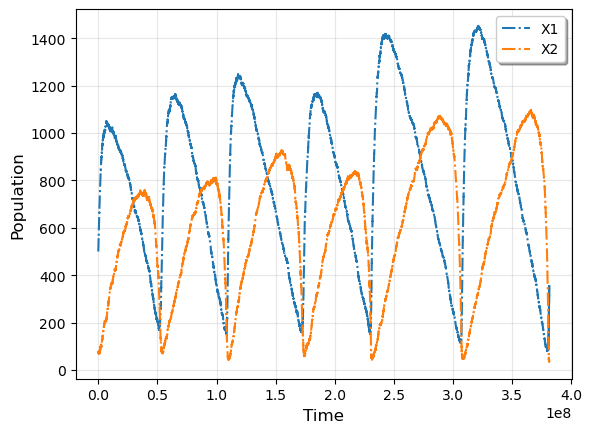

In [38]:
# Initialize the 2 populations at time t = 0
C[0,0] = 500
C[1,0] = 76
    
# Gillespie steps
C, T, R = gillespie_step(C, T, K, steps, verbose = False)

# plot of simulation
fig, ax = plt.subplots()
ax.plot(T, C[0], '-.', label='X1')
ax.plot(T, C[1], '-.', label='X2')
legend = ax.legend(loc='best', shadow=True)
ax.grid('--', alpha= 0.3)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
plt.show()

Starting from a configuration near the equilibrium, we observe the expected oscillatory dynamics of preys (X1) and predators (X2).

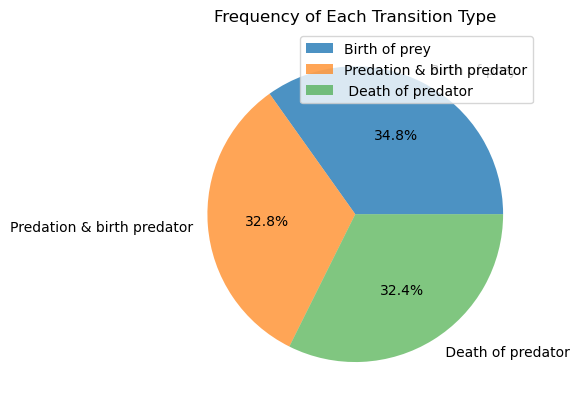

In [8]:
# Create the pie chart
colors = ['gold', 'royalblue', 'lightcoral']
reactions = ['Birth of prey', 'Predation & birth predator', ' Death of predator']
counts, bins = np.histogram(R)
wedge_info = plt.pie(list(filter(lambda x: x != 0, counts)), labels=reactions, autopct='%1.1f%%')

# Set desired alpha values 
patches = wedge_info[0] 
alpha_values = [0.8, 0.7, 0.6]  

# Loop through patches and set alpha
for i, patch in enumerate(patches):
    patch.set_alpha(alpha_values[i])

plt.title("Frequency of Each Transition Type")
plt.legend()
plt.show()


#### Lotka-Volterra simulation with Gillespie algorithm far from equilibrium

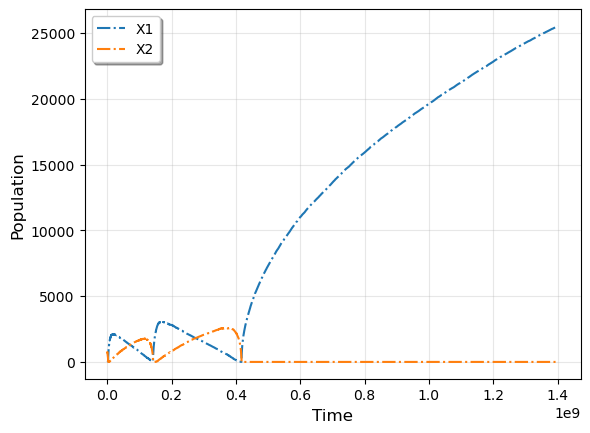

In [45]:
steps = 50000
T = np.zeros(steps+1)
X = np.zeros(steps+1) #prey
Y = np.zeros(steps+1) #predator
C = np.array([X,Y])

# Initialize the 2 populations at time t = 0
C[0,0] = 100 # prey
C[1,0] = 800 # predators
    
# Gillespie steps
C, T, R = gillespie_step(C, T, K, steps, verbose = False)

# plot of simulation
fig, ax = plt.subplots()
ax.plot(T, C[0], '-.', label='X1')
ax.plot(T, C[1], '-.', label='X2')
legend = ax.legend(loc='best', shadow=True)
ax.grid('--', alpha= 0.3)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
plt.show()

The predators after a certain amount of time become extinct completely. In this case, the population of preys explodes.

## 7.2 - Brusselator
Run some simulations of the Brussellator model with the Gillespie algorithm, using $a = 2, b = 5$
and for different volume sizes: $\Omega = 10^2, 10^3, 10^4$. What can one note by varying $\Omega$?

###### Discussion
Varying the volume size reveals notable differences in simulation behavior. Firstly, it's evident that adjusting volume affects the stabilization time of oscillations. Larger volumes tend to stabilize more quickly compared to smaller ones. 
For small volumes one can observe oscillations after $\sim 10^7 s$ while for larger volumes this number increase ip to $\sim 10^{12}$.

This is due to the effects of the volume on the reaction rates. The first reaction is encouraged at high volumes while the tird is discouraged at higher volumes. Also, the average values for the numbers X, Y of molecules of two species is much higher in the case of higher volume.

Moreover, decreasing the volume accentuates fluctuations within the system. In smaller volumes, stochastic fluctuations play a more pronounced role due to the reduced number of molecules. Consequently, each reaction holds greater relative significance, leading to heightened fluctuations in system behavior.

In [2]:
def gillespie_step(C, T, steps):
    
    '''
    Inputs:
    
    - C = array containing void arrays of the population, C.shape = (#populations)x(timesteps)
     (ex.: C = [(X1,....), (X2, ..)] 
    
    - T = array to store times
    - K = array containing the rate constants
    - steps = number of reactions per trajectory
    
    '''
    
    ###### Initialize populations ######
    n = C.shape[0]  

    # store the choosen reaction
    R = np.zeros(steps+1)
    
    ###### Main Code Loop ######
    for i in range(steps):

        # Compute updated overall reaction rate
        w = compute_w(C, a, b, V, i)
        lambda_c = sum(w)

        # Calculate time to next reaction
        tau = np.random.exponential(lambda_c, 1)
        T[i+1] = T[i] + tau[0]

        # Select which reaction to occur
        r = np.random.uniform(0,1)
        p = np.cumsum(w) / lambda_c
            
        reaction_index = np.searchsorted(p, r)
        diff_x, diff_y = reaction(reaction_index)
        C[0, i+1] = C[0, i] + diff_x
        C[1, i+1] = C[1, i] + diff_y
        
        # Store the reaction
        R[i] = reaction_index
        
    return (C, T, R)

In [3]:
###### Fix model parameters ######
a = 2
b = 5
V = 1e2
steps = 100000    # Number of reactions per trajectory

# Set up holder arrays
T = np.zeros(steps+1)
X = np.zeros(steps+1) #prey
Y = np.zeros(steps+1) #predator
C = np.array([X,Y])

def reaction(reaction_index):
    if reaction_index == 0:
        diff_x = + 1
        diff_y = 0
    elif reaction_index == 1:
        diff_x = - 1
        diff_y = 0
    elif reaction_index == 2:
        diff_x = + 1
        diff_y = - 1
    else:
        diff_x = - 1
        diff_y = + 1
    return (diff_x, diff_y)

def compute_w(C, a, b, V, i):
    w = np.array([a*V, C[0,i], C[0,i]*C[1,i]*(C[0,i]-1)/V**2, b*C[0,i]])
    return w

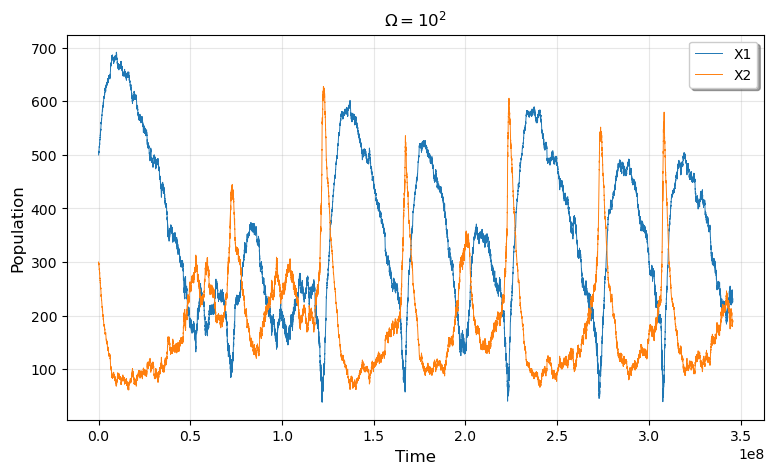

In [13]:
# Initialize the 2 populations at time t = 0
C[0,0] = 500
C[1,0] = 300

C, T, R = gillespie_step(C, T, steps)

# plot of simulation
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(T, C[0], '-', linewidth = 0.7, label='X1')
ax.plot(T, C[1], '-', linewidth = 0.7, label='X2')
legend = ax.legend(loc='best', shadow=True)
ax.grid('--', alpha= 0.3)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_title(f'$\Omega = 10^2$')
plt.show()

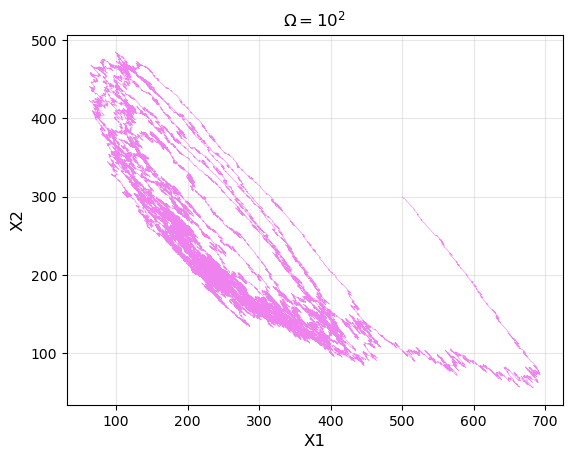

In [15]:
V = 1e2
C, T, R = gillespie_step(C, T, steps)

# plot of simulation
plt.plot(C[0], C[1], linestyle='-', linewidth = 0.4, color = 'violet')
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.title(f'$\Omega = 10^2$')
plt.grid('--', alpha= 0.3)


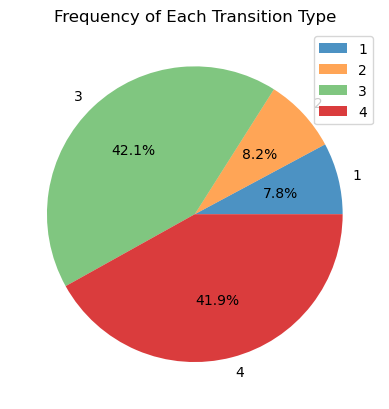

In [18]:
# Create the pie chart
colors = ['gold', 'royalblue', 'lightcoral']
reactions = ['1', '2', '3', '4']
counts, bins = np.histogram(R)
wedge_info = plt.pie(list(filter(lambda x: x != 0, counts)), labels=reactions, autopct='%1.1f%%')

# Set desired alpha values 
patches = wedge_info[0] 
alpha_values = [0.8, 0.7, 0.6, 0.9]  

# Loop through patches and set alpha
for i, patch in enumerate(patches):
    patch.set_alpha(alpha_values[i])

plt.title("Frequency of Each Transition Type")
plt.legend()
plt.show()


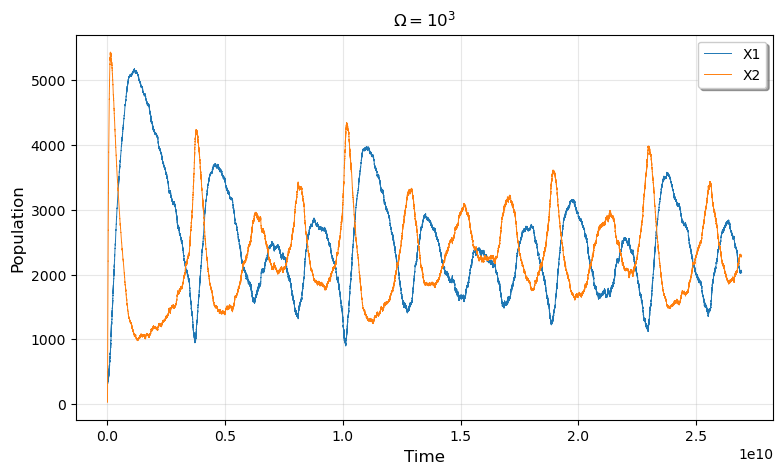

In [30]:
# parameters
V = 1e3
steps = 1000000

# Set up holder arrays
T = np.zeros(steps+1)
X = np.zeros(steps+1) #X molecules
Y = np.zeros(steps+1) #Y molecules
C = np.array([X,Y])

# Initialize the 2 populations at time t = 0
C[0,0] = 500
C[1,0] = 30

C, T, R = gillespie_step(C, T, steps)

# plot of simulation
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(T, C[0], '-', linewidth = 0.7, label='X1')
ax.plot(T, C[1], '-', linewidth = 0.7, label='X2')
legend = ax.legend(loc='best', shadow=True)
ax.grid('--', alpha= 0.3)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_title(f'$\Omega = 10^3$')
plt.show()

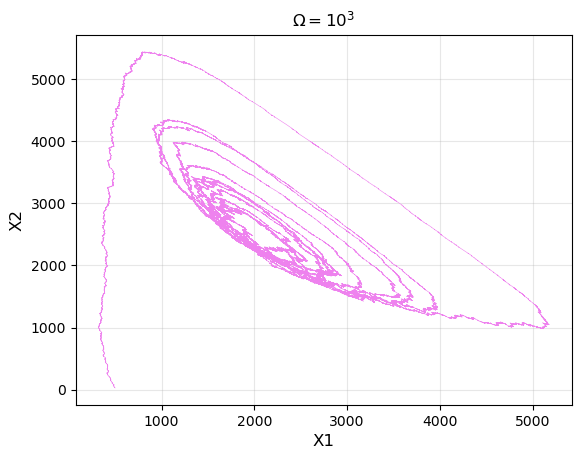

In [31]:
# plot of simulation
plt.plot(C[0], C[1], linestyle='-', linewidth = 0.4, color = 'violet')
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.title(f'$\Omega = 10^3$')
plt.grid('--', alpha= 0.3)


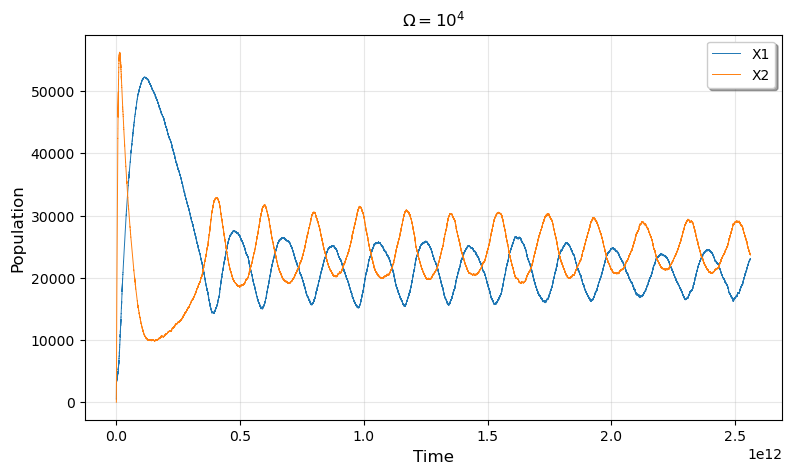

In [4]:
# parameters
V = 1e4
steps = 10000000

# Set up holder arrays
T = np.zeros(steps+1)
X = np.zeros(steps+1) #X molecules
Y = np.zeros(steps+1) #Y molecules
C = np.array([X,Y])

# Initialize the 2 populations at time t = 0
C[0,0] = 500
C[1,0] = 30

C, T, R = gillespie_step(C, T, steps)

# plot of simulation
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(T, C[0], '-', linewidth = 0.7, label='X1')
ax.plot(T, C[1], '-', linewidth = 0.7, label='X2')
legend = ax.legend(loc='best', shadow=True)
ax.grid('--', alpha= 0.3)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_title(f'$\Omega = 10^4$')
plt.show()

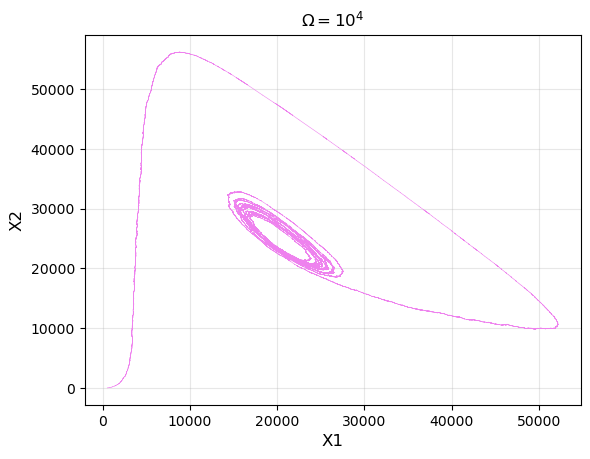

In [6]:
# plot of simulation
plt.plot(C[0], C[1], linestyle='-', linewidth = 0.4, color = 'violet')
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.title(f'$\Omega = 10^4$')
plt.grid('--', alpha= 0.3)


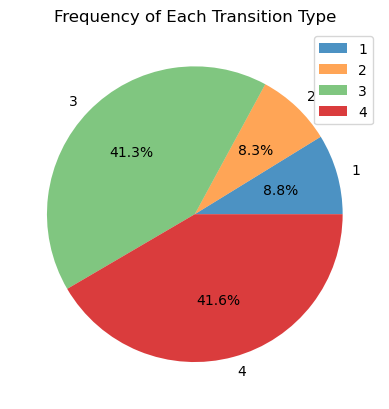

In [7]:
# Create the pie chart
colors = ['gold', 'royalblue', 'lightcoral']
reactions = ['1', '2', '3', '4']
counts, bins = np.histogram(R)
wedge_info = plt.pie(list(filter(lambda x: x != 0, counts)), labels=reactions, autopct='%1.1f%%')

# Set desired alpha values 
patches = wedge_info[0] 
alpha_values = [0.8, 0.7, 0.6, 0.9]  

# Loop through patches and set alpha
for i, patch in enumerate(patches):
    patch.set_alpha(alpha_values[i])

plt.title("Frequency of Each Transition Type")
plt.legend()
plt.show()
